<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/%EB%AF%B8%EB%8B%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%20/%203%E1%84%8C%E1%85%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import문

In [ ]:
# sys
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import time
import pickle

import numpy as np
import pandas as pd

# visualize
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트
from matplotlib import rc # 폰트
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# tensorflow
import tensorflow as tf
## keras
from tensorflow.keras import layers, models, metrics, callbacks
## for modeling
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, LSTM, GRU, Attention, Concatenate, Flatten, Normalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
## preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
## utils
from tensorflow.keras.utils import plot_model

# notification
# from knockknock import desktop_sender
from tqdm.notebook import tqdm
tqdm.pandas()

# customization
## tqdm (with ANSI escape codes)
dark_green = "\033[1;32;40m"
bar_format = f"{dark_green}{{l_bar}}{{bar:50}} [{{elapsed}}]{{r_bar}}"

## font
# plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = True


## Configuration

### Hyper Parameter

In [ ]:
# data amount
NUM_SAMPLES = 3000000
VAL_RATIO = 0.005

# Preprocess
ENC_TOKENIZER_LIMIT = None
DEC_TOKENIZER_LIMIT = None
ENC_PAD_MAXLEN = 20
DEC_PAD_MAXLEN = 30

# Vector Dimension
HIDDEN_DIM = 300  # Latent dimensionality of the encoding space.
EMBEDDING_DIM = 400

# Compile, Fit
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 100


## Extra Options
REVERSE = True
DECAY = None

### Path

In [ ]:
# Load Preprocessed Data
MY_DRIVE_PRE_DIR = '/content/drive/MyDrive/Colab Notebooks/AI 부트캠프 Projects/NMT_Attention(논문구현)/preprocessed data/'
LOCAL_PRE_DIR = '/Users/GitHub/Projects/AI_Project/03_논문구현/preprocessed data/'
REMOTE_PRE_DIR = 'preprocessed'

# Checkpoints

MY_DRIVE_CHK_DIR = '/content/drive/MyDrive/checkpoint/Attention/'
LOCAL_CHK_DIR = '/Users/GitHub/Projects/AI_Project/03_논문구현/checkpoint/Attention/'
REMOTE_CHK_DIR = ''

PRE_DIR = LOCAL_PRE_DIR
CHK_DIR = LOCAL_CHK_DIR
CHK_NAME = f'Att_2Layer_NUM_SAMPLES_{str(NUM_SAMPLES)[:-4]}만.h5'

print(f'체크포인트 저장 경로: {CHK_DIR}')
print(f'체크포인트 파일명: {CHK_NAME}')

체크포인트 저장 경로: /Users/GitHub/Projects/AI_Project/03_논문구현/checkpoint/Attention/
체크포인트 파일명: Att_2Layer_NUM_SAMPLES_300만.h5


### 데이터 전처리

## 데이터 불러오기


In [ ]:
with open(f'{PRE_DIR}/{NUM_SAMPLES}/ko_corpus.pkl', 'rb') as f:
    ko_corpus = pickle.load(f)
    f.close()

with open(f'{PRE_DIR}/{NUM_SAMPLES}/en_corpus.pkl', 'rb') as f:
    en_corpus = pickle.load(f)
    f.close()

with open(f'{PRE_DIR}/{NUM_SAMPLES}/sents_ko_in.pkl', 'rb') as f:
    sents_ko_in = pickle.load(f)
    f.close()

with open(f'{PRE_DIR}/{NUM_SAMPLES}/sents_en_in.pkl', 'rb') as f:
    sents_en_in = pickle.load(f)
    f.close()

with open(f'{PRE_DIR}/{NUM_SAMPLES}/sents_en_out.pkl', 'rb') as f:
    sents_en_out = pickle.load(f)
    f.close()

# ko_corpus, en_corpus 리스트로 변환
ko_corpus = ko_corpus[:1500000]
en_corpus = en_corpus[:1500000]
sents_ko_in = sents_ko_in[:1500000]
sents_en_in = sents_en_in[:1500000]
sents_en_out = sents_en_out[:1500000]



# 결과 확인(데이터 수 확인)
print('-- 결과 확인(데이터 수 확인) --')
print(f'설정 데이터 수: {NUM_SAMPLES}')
print(len(sents_ko_in), len(sents_en_in), len(sents_en_out))

# 결과 확인(3개씩 문장 확인)
print()
print('-- 결과 확인(3개씩 문장 확인) --')
print(f'인코더의 입력 :\n,{sents_ko_in[-3:]}\n')
print(f'디코더의 입력 :\n,{sents_en_in[-3:]}\n')
print(f'디코더의 레이블 :\n,{sents_en_out[-3:]}\n')

### 데이터 탐색

In [ ]:
sents_ko_in_len = np.array(list(map((lambda x: len(x)), sents_ko_in)))
sents_en_in_len = np.array(list(map((lambda x: len(x)), sents_en_in)))

ko_len = np.unique(sents_ko_in_len, return_counts=True)
en_len = np.unique(sents_en_in_len, return_counts=True)

<Axes: >

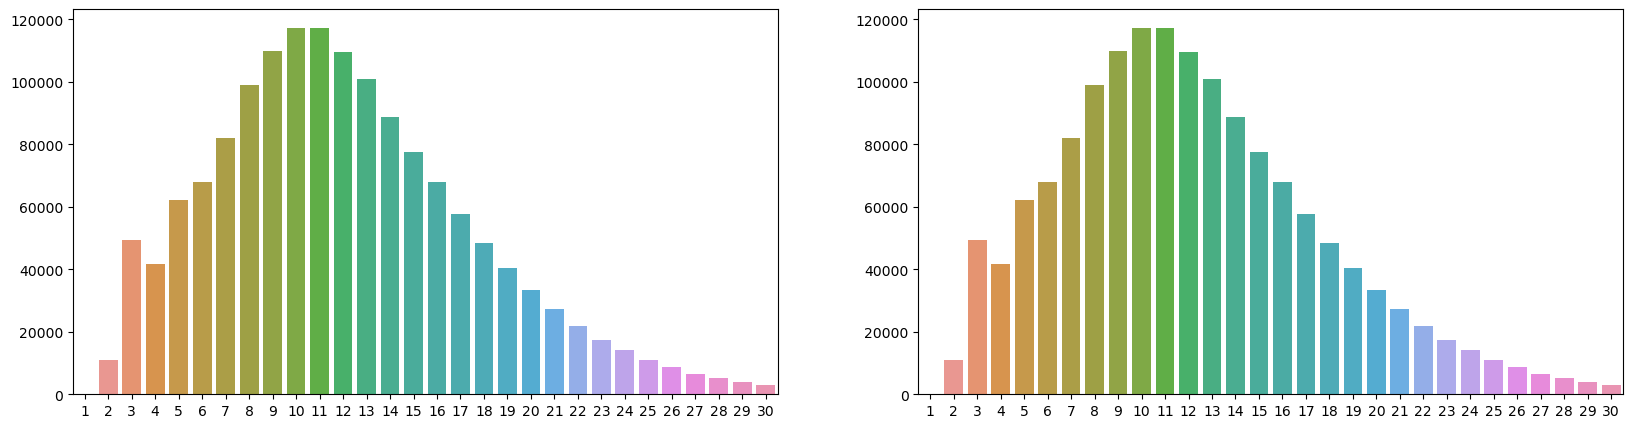

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.barplot(x=ko_len[0], y=ko_len[1], ax=ax[0])
sns.barplot(x=en_len[0], y=en_len[1], ax=ax[1])

## 데이터 전처리

### 단어집합(라벨링)

#### 한국어, 인코딩 데이터

In [ ]:
# 한국어 단어집합
tokenizer_enc = Tokenizer(ENC_TOKENIZER_LIMIT, filters='', lower=False, oov_token='<UNK>')
tokenizer_enc.fit_on_texts(sents_ko_in)

# 인코더 데이터
encoder_input = tokenizer_enc.texts_to_sequences(sents_ko_in)


# 영어 단어집합
tokenizer_dec = Tokenizer(DEC_TOKENIZER_LIMIT, filters='', lower=False, oov_token='<UNK>')
tokenizer_dec.fit_on_texts(sents_en_in)
tokenizer_dec.fit_on_texts(sents_en_out)

# 디코더 데이터
decoder_input = tokenizer_dec.texts_to_sequences(sents_en_in)
decoder_target = tokenizer_dec.texts_to_sequences(sents_en_out)

# 결과 확인
print(f'encoder_input: \n{encoder_input[-3:]}\n')
print(f'decoder_input: \n{decoder_input[-3:]}\n')
print(f'decoder_target: \n{decoder_target[-3:]}\n')

encoder_input: 
[[2, 232, 76, 28, 27, 91, 15082, 7578, 8, 2877, 67, 2857, 198, 13], [2, 6, 65, 5, 226, 17, 77], [2, 6, 269, 514, 1441, 11, 2513, 4194, 159, 255, 3]]

decoder_input: 
[[3, 233, 77, 29, 28, 92, 15083, 7579, 9, 2878, 68, 2858, 199, 14], [3, 7, 66, 6, 227, 18, 78], [3, 7, 270, 515, 1442, 12, 2514, 4195, 160, 256, 2]]

decoder_target: 
[[233, 77, 29, 28, 92, 15083, 7579, 9, 2878, 68, 2858, 199, 14, 4], [7, 66, 6, 227, 18, 78, 4], [7, 270, 515, 1442, 12, 2514, 4195, 160, 256, 2, 4]]



In [ ]:
# 단어집합 크기 저장
SRC_VOCAB_SIZE = len(tokenizer_enc.word_index) + 1
TAR_VOCAB_SIZE = len(tokenizer_dec.word_index) + 1

# 단어:라벨, 라벨:단어 딕셔너리 저장
src2idx = tokenizer_enc.word_index
idx2src = tokenizer_enc.index_word
tar2idx = tokenizer_dec.word_index
idx2tar = tokenizer_dec.index_word

# 단어집합 크기 확인
print(f'한국어 단어집합 크기: {SRC_VOCAB_SIZE}')
print(f'영어 단어집합 크기: {TAR_VOCAB_SIZE}')

# # 딕셔너리 확인
# print(src2idx)
# print(idx2src)
# print(tar2idx)
# print(idx2tar)

# 패딩했을 때의 토큰 <PAD> 추가
idx2src[0] = '<PAD>'
idx2tar[0] = '<PAD>'

### 패딩

In [ ]:
# 각 데이터의 최대길이만큼 패딩(padding) 수행
if REVERSE:
    encoder_input = pad_sequences(sequences=encoder_input, maxlen=ENC_PAD_MAXLEN, padding='post')
else:
    encoder_input = pad_sequences(sequences=encoder_input, maxlen=ENC_PAD_MAXLEN, padding='pre')

decoder_input = pad_sequences(sequences=decoder_input, maxlen=DEC_PAD_MAXLEN, padding='post')
decoder_target = pad_sequences(sequences=decoder_target, maxlen=DEC_PAD_MAXLEN,  padding='post')

if REVERSE:
    #reverse -> 핵심입니다.
    encoder_input = encoder_input[:,::-1]


# 결과 확인
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

# 각 데이터의 최대길이 저장
MAX_ENC_LEN, MAX_DEC_LEN = encoder_input.shape[1], decoder_input.shape[1]

print(f'MAX_ENC_LEN: {MAX_ENC_LEN}')
print(f'MAX_DEC_LEN: {MAX_DEC_LEN}')

인코더의 입력의 크기(shape) : (1500000, 20)
디코더의 입력의 크기(shape) : (1500000, 30)
디코더의 레이블의 크기(shape) : (1500000, 30)
MAX_ENC_LEN: 20
MAX_DEC_LEN: 30


In [ ]:
print(f'encoder input sample: \n{encoder_input[0]}\n')
print(f'decoder input sample: \n{decoder_input[0]}\n')
print(f'decoder target sample: \n{decoder_target[0]}\n')

encoder input sample: 
[    0     0     3 10732     4    14  2726   953   389     5     7   798
    17   692  6042     8    10 26537 10732     2]

decoder input sample: 
[    3 10733 26538    11     9  6043   693    18   799     8     6   390
   954  2727    15     5 10733     2     0     0     0     0     0     0
     0     0     0     0     0     0]

decoder target sample: 
[10733 26538    11     9  6043   693    18   799     8     6   390   954
  2727    15     5 10733     2     4     0     0     0     0     0     0
     0     0     0     0     0     0]



### 학습 데이터, 테스트 데이터 분리

In [ ]:
# 데이터 섞기

## 랜덤 인덱스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(f'랜덤 시퀀스(인덱스): {indices}')

## 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

print()
print(f'encoder_input: \n{encoder_input[indices[0]]}\n')
print(f'decoder_input: \n{decoder_input[indices[1]]}\n')
print(f'decoder_target: \n{decoder_target[indices[1]]}\n')

랜덤 시퀀스(인덱스): [1209779  156869 1037712 ...  799523  884251  206591]

encoder_input: 
[   0    0    0    0    0    0    0    0    0    0    3 1638 1157    5
   67   95    7   62    6    2]

decoder_input: 
[    3    31    59   138     6   117    21   243  3558    21   243 14125
     2     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]

decoder_target: 
[   31    59   138     6   117    21   243  3558    21   243 14125     2
     4     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]



In [ ]:
# 데이터 분리
n_of_val = int(NUM_SAMPLES * VAL_RATIO)

# train_data
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# test_data
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]


# 결과 확인
print("train data's shape")
print(encoder_input_train.shape, decoder_input_train.shape, decoder_target_train.shape)
print("\ntest data's shape")
print(encoder_input_test.shape, decoder_input_test.shape, decoder_target_test.shape)

train data's shape
(1485000, 20) (1485000, 30) (1485000, 30)

test data's shape
(15000, 20) (15000, 30) (15000, 30)


## 모델링

### 인코더(Train)

In [ ]:
# 인코더(Train)

## layer
### Input
enc_inputs = Input(shape=(MAX_ENC_LEN, ), name='ENC_Input')
### Embedding
enc_embedding_layer = Embedding(input_dim=SRC_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length= MAX_ENC_LEN, mask_zero=True, name='ENC_Embedding')
### Normalization
enc_normalize_layer = Normalization(invert=False, name='ENC_Normalization')
### LSTM
enc_lstm1 = LSTM(units=HIDDEN_DIM, return_state=True, return_sequences=True,
                 dropout=0.2, # dropouts
                 name='ENC_LSTM-1')

enc_lstm2  = LSTM(units=HIDDEN_DIM, return_state=True, return_sequences=True,
                  dropout=0.2, # dropouts
                  name='ENC_LSTM-2')

## input -> output
### Input -> Embedding
enc_emb = enc_embedding_layer(enc_inputs)
### Normalizing
enc_normalized = enc_normalize_layer(enc_emb)
### Embedding -> LSTM -> LSTM/Output
enc_lstm1_sequences, enc_h1_state, enc_c1_state = enc_lstm1(enc_normalized)
enc_lstm2_sequences, enc_h2_state, enc_c2_state = enc_lstm2(enc_lstm1_sequences)

## 데이터 저장
enc_states_1 = [enc_h1_state, enc_c1_state]
enc_states_2 = [enc_h2_state, enc_c2_state]

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



### 디코더(Train)

In [ ]:
# 디코더(Train)


## layer
### Input
dec_inputs = Input(shape=(MAX_DEC_LEN, ), name='DEC_Input')
### Embedding
dec_embedding_layer = Embedding(input_dim=TAR_VOCAB_SIZE, output_dim=HIDDEN_DIM, input_length= MAX_DEC_LEN, mask_zero=True, name='DEC_Embedding')
### Normalization
dec_normalize_layer = Normalization(invert=False, name='DEC_Normalization')
### LSTM
dec_lstm1 = LSTM(units=HIDDEN_DIM, return_state=True, return_sequences=True,
                 dropout=0.2, # dropouts
                 name='DEC_LSTM-1')

dec_lstm2 = LSTM(units=HIDDEN_DIM, return_state=True, return_sequences=True,
                 dropout=0.2, # dropouts
                 name='DEC_LSTM-2')
# Attention
dec_attention_layer = Attention(score_mode='dot', name='DEC_Attention')
dec_concat_layer = Concatenate(name='DEC_Concat')
### Dense
dec_dense_tanh = Dense(units=HIDDEN_DIM, activation='tanh', name='DEC_Dense-tanh')
dec_dense_softmax = Dense(units=TAR_VOCAB_SIZE, activation='softmax', name='DEC_Dense-softmax')

## input -> output
### Input -> Embedding
dec_emb = dec_embedding_layer(dec_inputs)
### Normalizing
dec_normalized = dec_normalize_layer(dec_emb)
### Embedding -> LSTM -> LSTM
dec_lstm1_sequences, dec_h1_state, dec_c1_state = dec_lstm1(dec_normalized, initial_state=enc_states_1)
dec_lstm2_sequences, dec_h2_state, dec_c2_state = dec_lstm2(dec_lstm1_sequences, initial_state=enc_states_2)
### Attention, Concatenate
dec_att_context_vec = dec_attention_layer([dec_lstm2_sequences, enc_lstm2_sequences], training=True)
dec_concatted = dec_concat_layer([dec_att_context_vec, dec_lstm2_sequences])
### Dense
dec_h_tilda = dec_dense_tanh(dec_concatted)
dec_y_hat = dec_dense_softmax(dec_h_tilda)

### 컴파일 및 summary

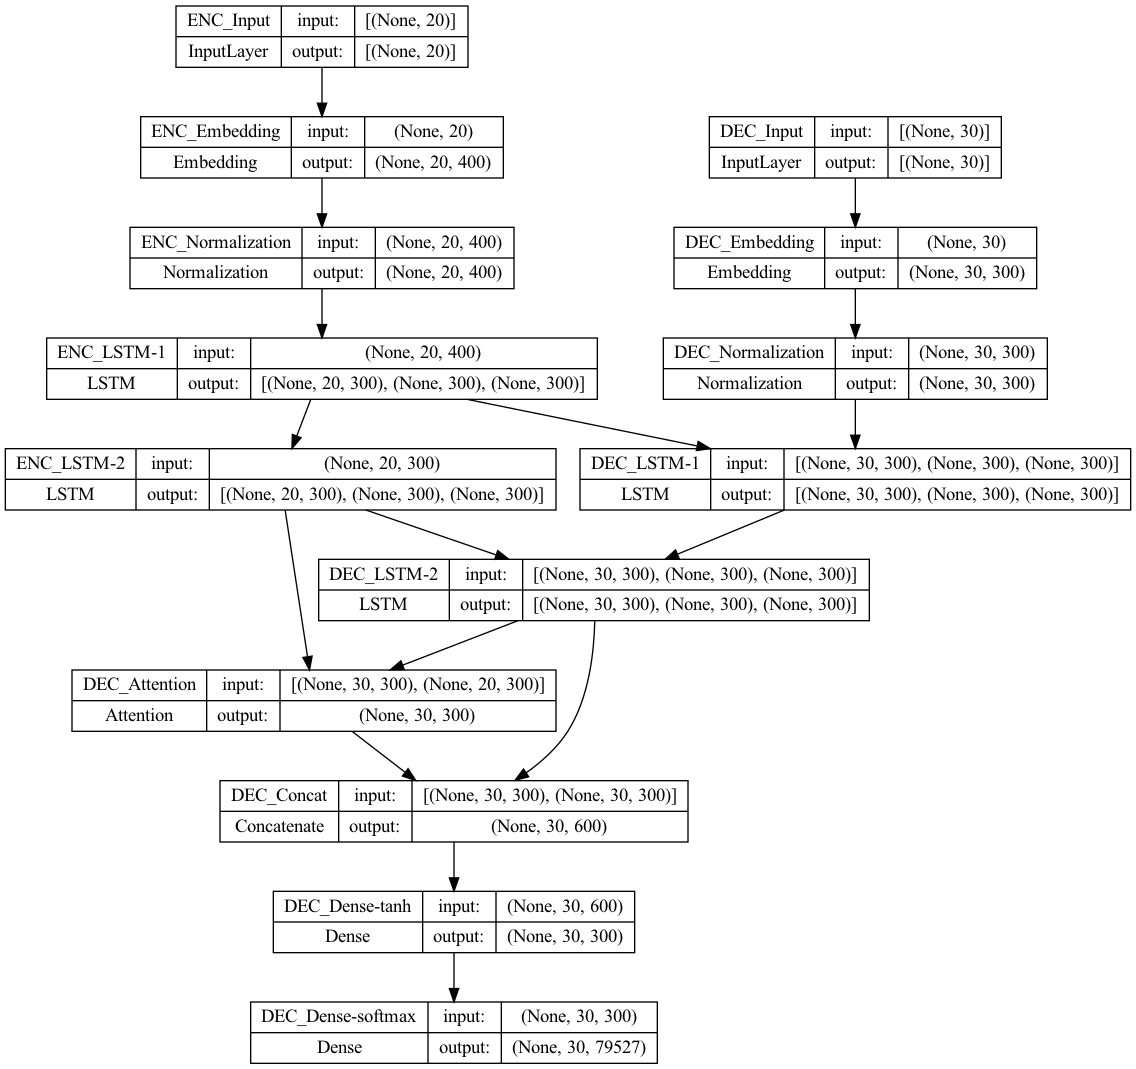

In [ ]:
# 모델 입출력 정의
model = Model(inputs=[enc_inputs, dec_inputs], outputs=dec_y_hat)

# compile
model.compile(
    optimizer = Adam(learning_rate=LEARNING_RATE),
    loss = 'sparse_categorical_crossentropy',
    metrics = 'sparse_categorical_accuracy'
)

# summary
# model.summary()

# plot
plot_model(model, show_shapes=True)

### 학습

In [ ]:
# 콜백함수
es = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)
chk = ModelCheckpoint(filepath=CHK_DIR + CHK_NAME,
                      monitor='val_loss',
                      save_best_only=True,
                      mode='min',
                      verbose=0
                      )


# @desktop_sender(title='Attention 1-layer')
def action():
    history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                        validation_data=[[encoder_input_test, decoder_input_test], decoder_target_test],
                        batch_size=BATCH_SIZE,
                        callbacks=[es, chk],
                        epochs=EPOCHS,
                        verbose=1)

    return history

history = action()

Epoch 1/100
46407/46407 [==============================] - 5446s 117ms/step - loss: 0.3360 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.1109 - val_sparse_categorical_accuracy: 0.9859 - lr: 0.0010
Epoch 2/100
46407/46407 [==============================] - 5439s 117ms/step - loss: 0.1000 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0938 - val_sparse_categorical_accuracy: 0.9884 - lr: 0.0010
Epoch 3/100
46407/46407 [==============================] - 5439s 117ms/step - loss: 0.0841 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0852 - val_sparse_categorical_accuracy: 0.9895 - lr: 0.0010
Epoch 4/100
46407/46407 [==============================] - 5438s 117ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.0802 - val_sparse_categorical_accuracy: 0.9901 - lr: 0.0010
Epoch 5/100
 2061/46407 [>.............................] - ETA: 1:26:21 - loss: 0.0681 - sparse_categorical_accuracy: 0.9905

## 중간 결과 확인(시각화)

### 시각화

In [ ]:
# 체크포인트 불러오기
# model.load_weights(CHK_DIR + CHK_NAME)
model.load_weights('/Users/GitHub/Projects/AI_Project/03_논문구현/Model/Attention/Att_2Layer_NUM_SAMPLES_300만.h5')

In [ ]:
# visualize
def visualizer(history=history, metrics='sparse_categorical_accuracy'):

    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=("Loss", "SC Accuracy"))

    # train loss
    fig.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['loss'],
                             mode='lines+markers',
                             name='Train Loss'
                             ),
                  row=1, col=1)

    # test loss
    fig.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['val_loss'],
                             mode='lines+markers',
                             name='Val Loss'
                             ),
                  row=1, col=1)

    # train score
    fig.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['sparse_categorical_accuracy'],
                             mode='lines+markers',
                             name='Train SCA'
                             ),
                  row=1, col=2)

    # test score
    fig.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['val_sparse_categorical_accuracy'],
                             mode='lines+markers',
                             name='Val SCA'
                             ),
                  row=1, col=2)

    fig.update_layout(showlegend=True)
    fig.show()

visualizer(history)

## Inference

### 모델링

#### 인코더

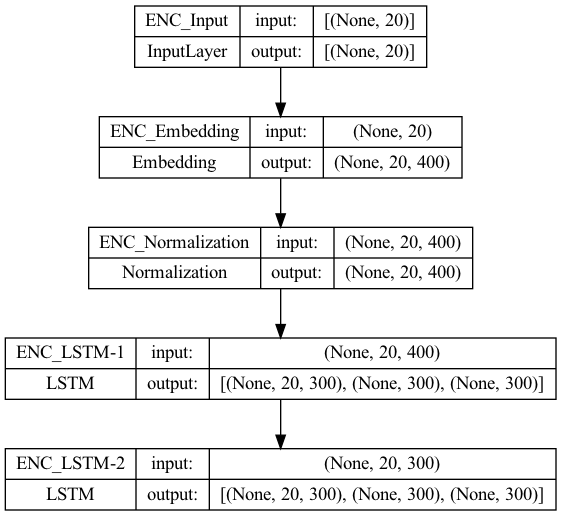

In [ ]:
# 인코더
enc_model = Model(inputs=enc_inputs, outputs=[enc_lstm2_sequences, enc_states_1, enc_states_2])

# 시각화
plot_model(enc_model, show_shapes=True)

#### 디코더(Predict)

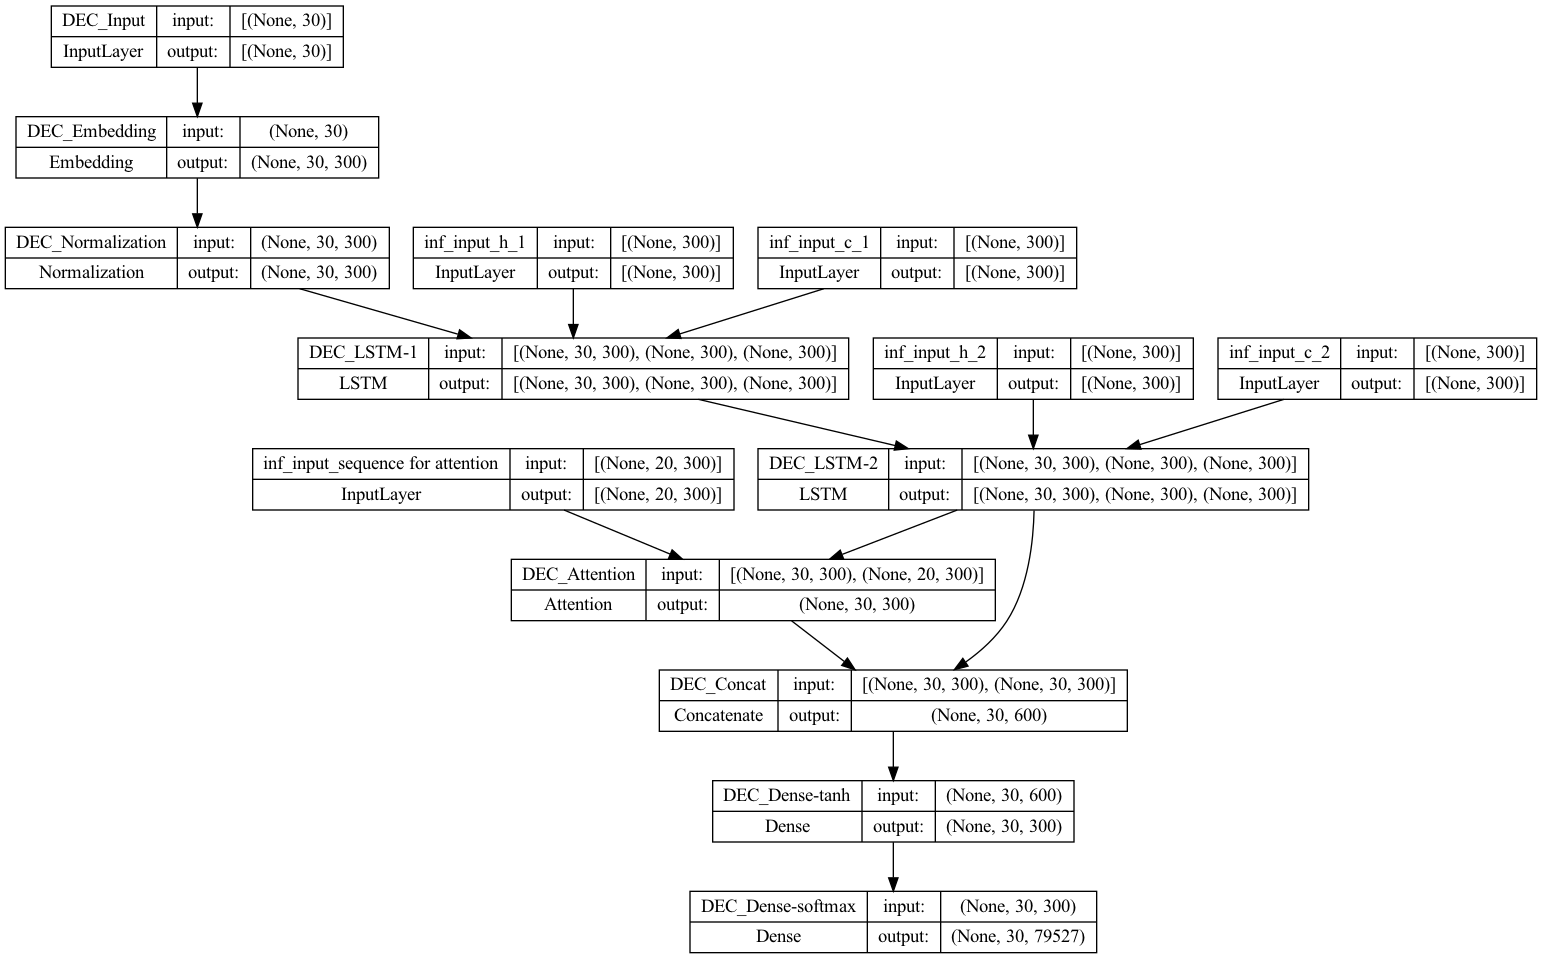

In [ ]:
# 디코더 (Inference, inf: 위의 디코더 섹션과의 혼동을 막기 위해 inf로 명명.)
## layer
### Input: 이전 시점의 상태를 보관할 텐서
inf_input_sequences = Input(shape=(MAX_ENC_LEN, HIDDEN_DIM), name='inf_input_sequence for attention')

inf_input_h_1 = Input(shape=(HIDDEN_DIM,), name='inf_input_h_1')
inf_input_c_1 = Input(shape=(HIDDEN_DIM,), name='inf_input_c_1')
inf_input_h_2 = Input(shape=(HIDDEN_DIM,), name='inf_input_h_2')
inf_input_c_2 = Input(shape=(HIDDEN_DIM,), name='inf_input_c_2')

inf_states_inputs_1 = [inf_input_h_1, inf_input_c_1]
inf_states_inputs_2 = [inf_input_h_2, inf_input_c_2]

## Input -> Output
### Input -> dec_Embedding: 훈련 때 사용했던 임베딩 층 재활용
inf_emb = dec_embedding_layer(dec_inputs)
### Normalizing
inf_normalized = dec_normalize_layer(inf_emb)
### Embedding -> LSTM -> LSTM:  다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
inf_lstm1_sequences, inf_state_h_1, inf_state_c_1 = dec_lstm1(inf_normalized, initial_state=inf_states_inputs_1)
inf_lstm2_sequences, inf_state_h_2, inf_state_c_2 = dec_lstm2(inf_lstm1_sequences, initial_state=inf_states_inputs_2)

inf_lstm1_states = [inf_state_h_1, inf_state_c_1]
inf_lstm2_states = [inf_state_h_2, inf_state_c_2]
# Attention
inf_att_context_vec = dec_attention_layer([inf_lstm2_sequences, inf_input_sequences], training=False)
inf_concatted = dec_concat_layer([inf_att_context_vec, inf_lstm2_sequences])
inf_h_tilda = dec_dense_tanh(inf_concatted)
inf_y_hat = dec_dense_softmax(inf_h_tilda)

## 수정된 디코더
dec_model = Model(inputs=[dec_inputs] + [inf_input_sequences, inf_states_inputs_1, inf_states_inputs_2],
                  outputs= [inf_y_hat] + [inf_lstm2_sequences, inf_lstm1_states, inf_lstm2_states])

# 시각화
plot_model(dec_model, show_shapes=True)

### Decode Sequence

In [ ]:
# 원문에서도 영어가 껴있고, 어차피 조사만 따로 버릴 것도 아니기에 한국어, 영어 동일하게 전처리 하겠습니다.
def preprocess_sentence(sent):
    sent = re.sub(r"([?.!,¿])", r" \1", sent) # 구두점 앞 공백 추가
    sent = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent) # 다수의 공백을 하나의 공백으로 치환

    return sent


# 학습 데이터, 타겟 데이터 생성 함수
def load_preprocessed_data(ko_corpus, en_corpus, debug=False):
    encoder_input, decoder_input, decoder_target = [], [], []
    # encoder_input: encoder layer에 들어갈 학습 데이터
    # decoder_input: decoder layer에 들어갈 학습 데이터(teacher forcing용)
    # decoder_target: decoder layer에서 나온 결과랑 비교할 타겟 데이터

    for i, (src_line, tar_line) in enumerate(zip(ko_corpus, en_corpus)):

        # source 데이터 (scr_lin) 전처리
        src_line = [w for w in preprocess_sentence(src_line).split()]

        # target 데이터 (tar_line) 전처리
        tar_line = preprocess_sentence(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()] # target for teacher forcing
        tar_line_out = [w for w in (tar_line + " <eos>").split()] # final target

        # reverse
        # src_line.reverse()

        # append
        encoder_input.append(src_line) # 클리닝
        decoder_input.append(tar_line_in) # sos + 클리닝
        decoder_target.append(tar_line_out) # 클리닝 + eos

        if i == NUM_SAMPLES - 1:
            break


        # debugging section
        if debug:
            print(f'(debug) 첫 번째 문장 작업 결과')
            print(f'src_line: \n{src_line}\n')
            print(f'tar_line_in: \n{tar_line_in}\n')
            print(f'tar_line_out: \n{tar_line_out}\n')
            break

    return encoder_input, decoder_input, decoder_target

In [ ]:
def translate(sentence):
    # 전처리

    #   전처리 함수
    sentence = preprocess_sentence(sentence)
    tokens = sentence.split(" ")

    # reverse
    if REVERSE:
        tokens.reverse()

    #   라벨링
    enc_input = tokenizer_enc.texts_to_sequences([tokens])

    #   패딩
    enc_input = pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='pre')
    inf_enc_state_sequences, inf_enc_state_value_1, inf_enc_state_value_2 = enc_model.predict(enc_input)

    #   Decoder input인 <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1)) # 패딩 후 array로 반환되기 때문에 마찬가지로 array로 맞춰준다.
    target_seq[0, 0] = tar2idx['<sos>']

    # Prediction 시작
        # stop_condition이 True가 될 때까지 루프 반복
        # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.

    stop_condition=False
    dec_sentence=''

## 수정된 디코더 ##

    for i in range(MAX_DEC_LEN):

        # 이전 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, previous_lstm1_sequences, previous_lstm1_states, previous_lstm2_states = dec_model.predict(x=[target_seq] + [inf_enc_state_sequences, inf_enc_state_value_1, inf_enc_state_value_2], verbose=0)
        # 예측 결과를 단어로 변환
        result_token_index = np.argmax(output_tokens[0, -1, :])
        result_word = idx2tar[result_token_index]
        # 현재 시점의 예측 단어를 예측 문장에 추가
        dec_sentence += ' ' + result_word

        # 현재 시점의 예측 결과 -> 다음 시점의 입력으로 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0,0] = result_token_index
        # 현재 시점의 상태 -> 다음 시점의 상태로 업데이트
        inf_enc_state_sequences, inf_enc_state_value_1, inf_enc_state_value_2  = previous_lstm1_sequences, previous_lstm1_states, previous_lstm2_states

        # Stop condition <eos>에 도달하면 중단
        if result_word == '<eos>':
            break

    return dec_sentence.strip(' <eos>')

## 결과 확인

In [ ]:
train_idx = indices[:-n_of_val]
test_idx = indices[-n_of_val:]

# 아무 문장이나 선택
n_samples = 5
np.random.choice(train_idx, n_samples)

array([1263095,   64787,  611998,  225697, 1286766])

In [ ]:
# train data - translate

n_samples = 5
for idx in np.random.choice(train_idx, n_samples):
    test_sentence = ko_corpus[idx]
    answer_sentence = en_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence)
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 17ms/step
입력문장 : >아씨.
정답문장 : >Mrs.
번역문장 : The limited living by including them five .
--------------------------------------------------
1/1 [==============================] - 0s 13ms/step
입력문장 : 매우 많은 행사에 참여했습니다.
정답문장 : I used to attend so many events.
번역문장 : The living texture including between the high take .
--------------------------------------------------
1/1 [==============================] - 0s 13ms/step
입력문장 : >옴마야~
정답문장 : >Oh my!
번역문장 : The living living by making some ingredients .
--------------------------------------------------
1/1 [==============================] - 0s 14ms/step
입력문장 : 매트리스 50개를 도매로 사고 싶어요.
정답문장 : I'd like to buy 50 mattress for wholesale.
번역문장 : The plan must have to clean various company without living five .
--------------------------------------------------
1/1 [==============================] - 0s 13ms/step
입력문장 : 매일 구워달라고 해서 피곤할 지경입니다.
정답문장 : I'm tired because you ask me to grill it every day.
번역문장 : The p

In [ ]:
# test data - translate
n_samples = 5
for idx in np.random.choice(test_idx, n_samples):
    test_sentence = ko_corpus[idx]
    answer_sentence = en_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence)
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 26ms/step
입력문장 : 다만, 저희가 진행하고 있는 프로젝트가 있기 때문에 임대 기간은 최소 3년 이상이었으면 합니다.
정답문장 : However, since there is a project we are working on, we hope that the lease period will be at least three years.
번역문장 : This year require high factory to do various company is . various high of skin and grow into high electric pressure into their days online take them .
--------------------------------------------------
1/1 [==============================] - 0s 13ms/step
입력문장 : 물론이지, 그러면 고맙지. 언제든지 이메일로 연락하면 돼.
정답문장 : Of course, I would appreciate that; you can always reach me by email.
번역문장 : The living of the new take some company by high amount .
--------------------------------------------------
1/1 [==============================] - 0s 13ms/step
입력문장 : 예, 우리는 최근에 자동차를 생산했습니다.
정답문장 : yes, we produced automobile recently.
번역문장 : The plan must have to clean various company without living five .
--------------------------------------------------
1/1 [=================

10만개일 때 test 결과
<br>
<br>

```
1/1 [==============================] - 0s 29ms/step
입력문장 : 그 때 비로소 그들이 늙게 되는 거야.
정답문장 : That is when they finally grow old.
번역문장 : They are also suffering from the summit the road the road .
--------------------------------------------------
1/1 [==============================] - 0s 31ms/step
입력문장 : 나는 예전부터 다른 나라 사람들하고 얘기하고 싶었어요.
정답문장 : Since the old days, I always wanted to talk to foreigners.
번역문장 : I m excited of the mayor of the French National Complex Complex Guard .
--------------------------------------------------
1/1 [==============================] - 0s 26ms/step
입력문장 : 내가 생각에는 자료가 잘못된 것 같아요.
정답문장 : I think data is wrong.
번역문장 : I m also surprised minded with the typhoon .
--------------------------------------------------
1/1 [==============================] - 0s 28ms/step
입력문장 : 네가 하는 말은 대부분 이해하지만 내 생각을 영어로 표현하는 게 어려워.
정답문장 : I almost understand what you say, but it's hard to express my thoughts.
번역문장 : I m also surprised because it s a big mountain run by your Instagram body pattern stably .
--------------------------------------------------
1/1 [==============================] - 0s 29ms/step
입력문장 : 당신이 왜 이러는지 나는 모르겠습니다.
정답문장 : I don't know why you are doing this.
번역문장 : I m also surprised because it s a hot mountain .
--------------------------------------------------
```

In [ ]:
# 제출용 답안

test_data = pd.read_csv('/Users/GitHub/Projects/AI_Project/03_논문구현/한영번역_타켓문장.csv')
test_data

,한글
0,정리가 필요하겠네요.
1,처음 만났을 때를 떠올려 보세요
2,구썸남 인스타에 좋아요 누름.
3,있었던 일을 차분히 생각해봐요.
4,많이 찍다보면 조금씩 실력이 늘거예요.
...,...
195,조심히 오세요.
196,잘 이겨내고 있네요.
197,궁금할 수 있어요.
198,안 사귀는 것보다 좋지요.


In [ ]:
# test
for sent in
    test_sentence = ko_corpus[idx]
    answer_sentence = en_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence)
    print("번역문장 :", decoded_sentence)
    print("-"*50)

SyntaxError: invalid syntax (880712564.py, line 2)

In [ ]:
test_translated = []
for sent in list(test_data['한글']):
    decoded_sentence = translate(sent)
    test_translated.append(decoded_sentence)
    print(decoded_sentence)
    # break

1/1 [==============================] - 0s 24ms/step
The limited living by including them five .
1/1 [==============================] - 0s 13ms/step
The plan must have to clean various company without living five .
1/1 [==============================] - 0s 13ms/step
The living texture including between the high take .
1/1 [==============================] - 0s 12ms/step
The living texture including between the high take .
1/1 [==============================] - 0s 13ms/step
The plan must have to clean various company without living five .
1/1 [==============================] - 0s 13ms/step
The living texture including between the high take .
1/1 [==============================] - 0s 12ms/step
The living texture including between the high take .
1/1 [==============================] - 0s 13ms/step
The living texture including between the high take .
1/1 [==============================] - 0s 13ms/step
The living and store of the and take .
1/1 [==============================] - 0s 13ms/step


In [ ]:
len(test_translated)

200

In [ ]:
test_translated[:5]

['The limited living by including them five .',
 'The plan must have to clean various company without living five .',
 'The living texture including between the high take .',
 'The living texture including between the high take .',
 'The plan must have to clean various company without living five .']

In [ ]:
translated_df = pd.DataFrame({'번역문': test_translated})
translated_df

,번역문
0,The limited living by including them five .
1,The plan must have to clean various company wi...
2,The living texture including between the high ...
3,The living texture including between the high ...
4,The plan must have to clean various company wi...
...,...
195,The limited living by including them five .
196,The living and store of the and take .
197,The living and store of the and take .
198,The living texture including between the high ...


In [ ]:
translated_df.to_csv('3조_한영번역_타겟번영문장.csv')